In [10]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

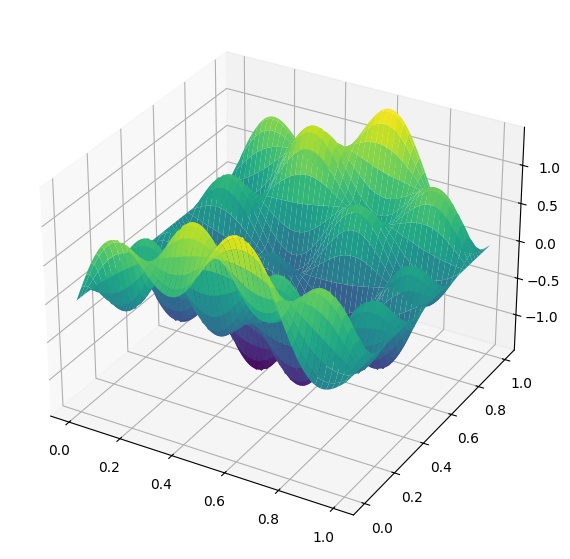

In [12]:
t = torch.linspace(0, 1, 100)
x = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x, t)

PI = torch.pi
def cos(x):
    return torch.cos(x)
def sin(x):
    return torch.sin(x)

def u(t, x):
    return sin(PI * x) * cos(2 * PI * t) + 0.5 * sin(4 * PI * x)*cos(8 * PI * t)

solution = u(T, X)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, solution, cmap='viridis')

In [13]:
from pinns.samplers import RandomRectangularSampler, ConstantSampler

# Constraints should be just (0, x), (t, 0), (t, 1)
def get_constraints():
    init_pts = torch.hstack(
        [torch.zeros((100, 1), requires_grad=True), x.reshape(-1, 1)]
    )
    left_pts = torch.hstack(
        [t.reshape(-1, 1), torch.zeros((100, 1))]
    )
    right_pts = torch.hstack(
        [t.reshape(-1, 1), torch.ones((100, 1))]
    )
    
    # Let initial values be tuple for u and du.
    init_values = torch.stack([
        u(init_pts[:,0], init_pts[:,1]),
        torch.zeros((100))
        ]).T
    left_values = u(left_pts[:,0], left_pts[:,1]).reshape(-1, 1)
    right_values = u(right_pts[:,0], right_pts[:,1]).reshape(-1, 1)
    
    return ((init_pts, left_pts, right_pts), 
            (init_values, left_values, right_values))
    
pts, vals = get_constraints()
constraints_sampler = ConstantSampler((pts, vals))

domain = {'t': [0, 1], 'x': [0, 1]}
collocation_sampler = RandomRectangularSampler(domain, 1024)

test_sampler = ConstantSampler((
    torch.hstack([X.reshape(-1, 1), T.reshape(-1, 1)]),
    solution.T.reshape(-1, 1)
))

In [14]:
from pinns.derivatives import Derivative

d = Derivative(method='autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred
    ):
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss(u, tx):
        ut = d(u, tx)[:,[0]]
        preds = torch.hstack([u, ut])
        return torch.mean(torch.square(preds - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        utt = d(u, t, orders = 2)
        uxx = d(u, x, orders = 2)
        return torch.mean(torch.square(utt - 4 * uxx))
    
    return (
        initial_loss(init_pred, init_pts), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [15]:
def get_ip_data(N):
    pts, data = test_sampler()
    
    step = len(pts) // N
    
    return pts[::step, :], data[::step, :]

def get_dists(pts, A = 0, B = 1):
    init_dists  = pts[:,0]
    left_dists  = (pts[:,1] - A).abs()
    right_dists = (pts[:,1] - B).abs()
    dists = torch.stack([init_dists, left_dists, right_dists]).T
    return dists.min(dim=1).values

ip_pts, ip_vals = get_ip_data(1000)
dists = get_dists(ip_pts)

In [16]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin
from pinns.optimizers import Adam
from pinns.metrics import l2

pinn = FF([2] + [32, 32] + [1], activ=nn.Tanh())

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75, 0.75, 0.75, 0.25],
)

num_iters = 5000

errors = []
def save_error():
    if trainer.iter == 0 or (trainer.iter + 1) % 25 == 0:
        preds = pinn(ip_pts).detach()
        error = (preds - ip_vals).abs().flatten()
        errors.append(error)

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics=[l2],
    test_sampler = test_sampler,
    training_start_callbacks=[save_error],
    epoch_end_callbacks=[save_error],
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

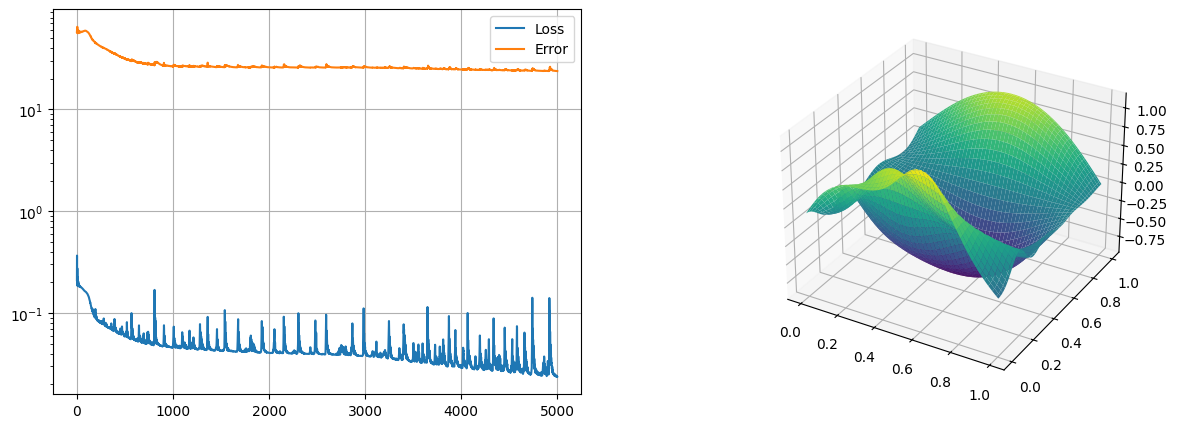

In [17]:
test_pts, test_vals = test_sampler()
test_pts = [
    test_pts[:,0].reshape(100, 100),
    test_pts[:,1].reshape(100, 100)
]

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
ax.plot(trainer.loss_history, label='Loss')
ax.plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='Error')
ax.grid()
ax.set_yscale('log')
ax.legend()

preds = pinn.predict(test_sampler()[0]).detach().reshape(100, 100)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(test_pts[1], test_pts[0], preds, cmap='viridis')

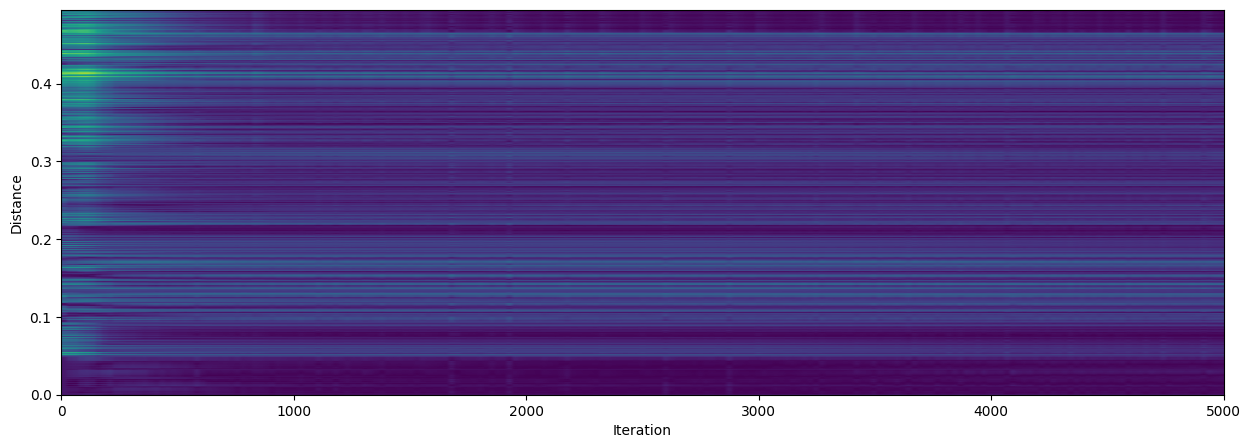

In [18]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 0].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()

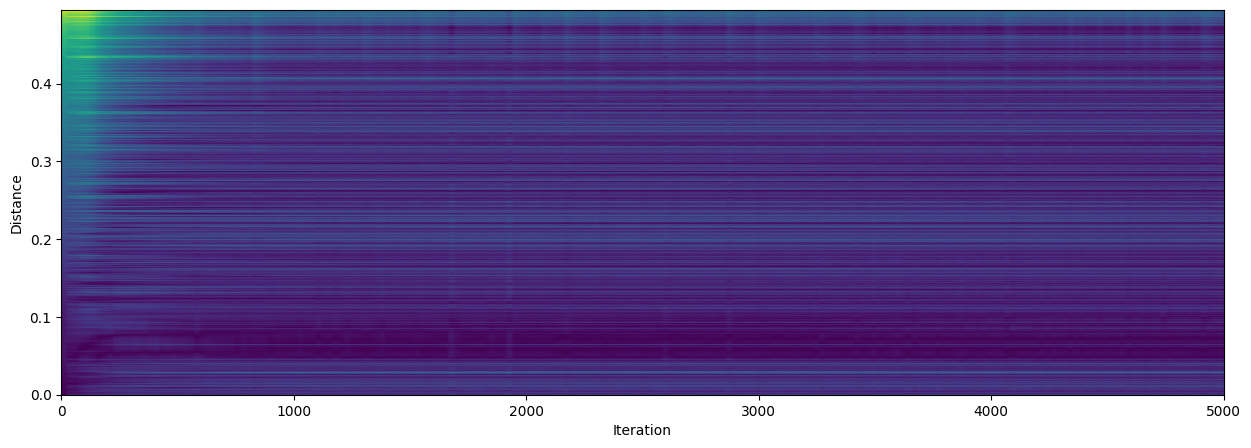

In [19]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 1].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()